In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [ ]:


# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")




In [ ]:
class MMNN_L(nn.Module):
    """Deterministic MMNN layer - used for non-Bayesian layers"""
    def __init__(
            self,
            in_features: int,
            out_features: int,
            width: int,
            device=None,
            activation=nn.Tanh()
    ) -> None:
        super().__init__()
        self.non_trainable = nn.Linear(in_features, width, device=device)
        self.trainable = nn.Linear(width, out_features, device=device)
        self.activation = activation
        
        self.non_trainable.weight.requires_grad = False
        self.non_trainable.bias.requires_grad = False

    def forward(self, x):
        return self.trainable(self.activation(self.non_trainable(x)))


class BayesianMMNN_L(PyroModule):
    """Bayesian MMNN layer - W,b are Bayesian, A,c are deterministic"""
    def __init__(
            self,
            in_features: int,
            out_features: int,
            width: int,
            layer_idx: int,  # Unique identifier for sample site naming
            device=None,
            prior_scale=1.0,
            activation=nn.Tanh()
    ) -> None:
        super().__init__()
        
        self.activation = activation
        self.layer_idx = layer_idx
        self.device = device
        
        prior_scale_tensor = torch.tensor(prior_scale, device=device)
        
        # Initialize a temporary linear layer to get weight shapes and init values
        temp_linear = nn.Linear(in_features, width, device=device)
        
        # Store init values and prior scale as buffers
        self.register_buffer('W_init', temp_linear.weight.data.clone())
        self.register_buffer('b_init', temp_linear.bias.data.clone())
        self.register_buffer('prior_scale', prior_scale_tensor)
        
        # Deterministic trainable layer (A, c)
        self.trainable = nn.Linear(width, out_features, device=device)

    def forward(self, x):
        # Sample W, b with UNIQUE names using layer_idx
        W = pyro.sample(
            f"W_{self.layer_idx}",
            dist.Normal(self.W_init, self.prior_scale).to_event(2)
        )
        b = pyro.sample(
            f"b_{self.layer_idx}",
            dist.Normal(self.b_init, self.prior_scale).to_event(1)
        )
        
        # Manual linear transformation: x @ W.T + b
        x = F.linear(x, W, b)
        x = self.activation(x)
        x = self.trainable(x)
        return x

In [ ]:
class BayesianMMNN(PyroModule):
    """MMNN with last n_bayesian_layers having Bayesian W,b"""
    def __init__(
            self, 
            ranks, 
            widths, 
            device='cuda', 
            prior_scale=1.0,
            n_bayesian_layers=None
    ):
        super().__init__()
        
        self.depth = len(widths)
        self.device = device
        
        if n_bayesian_layers is None:
            n_bayesian_layers = self.depth
        n_bayesian_layers = max(0, min(n_bayesian_layers, self.depth))
        
        bayesian_start_idx = self.depth - n_bayesian_layers
        
        print(f"BayesianMMNN Configuration:")
        print(f"  Total layers: {self.depth}")
        print(f"  Deterministic layers: 0 to {bayesian_start_idx - 1}")
        print(f"  Bayesian layers: {bayesian_start_idx} to {self.depth - 1}")
        
        self.layers = nn.ModuleList()
        
        for j in range(self.depth):
            if j >= bayesian_start_idx:
                layer = BayesianMMNN_L(
                    in_features=ranks[j],
                    out_features=ranks[j+1],
                    width=widths[j],
                    layer_idx=j,  # Pass unique index for sample site naming
                    device=device,
                    prior_scale=prior_scale,
                    activation=nn.Tanh()
                )
            else:
                layer = MMNN_L(
                    in_features=ranks[j],
                    out_features=ranks[j+1],
                    width=widths[j],
                    device=device,
                    activation=nn.Tanh()
                )
            self.layers.append(layer)
    
    def forward(self, x, y=None):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        
        for layer in self.layers:
            x = layer(x)
        
        mu = x.squeeze()
        
        sigma = pyro.sample("sigma", dist.Gamma(
            torch.tensor(0.5, device=self.device),
            torch.tensor(1.0, device=self.device)
        ))
        
        with pyro.plate("data", mu.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu

In [ ]:

# ============================================================================

# Fixed BNN Class

# ============================================================================

class BNN(PyroModule):

    def __init__(self, in_dim=1, out_dim=1, hid_dim=128, prior_scale=1., device='cuda'):

        super().__init__()

        self.device = device

        self.activation = nn.Tanh()

        # Define layers

        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)

        self.layer15 = PyroModule[nn.Linear](hid_dim, hid_dim)

        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)        

        # FIXED: Create prior scale tensor on correct device

        prior_scale_tensor = torch.tensor(prior_scale, device=device)

        zero = torch.tensor(0., device=device)
        

        # Set layer parameters as random variables with device-aware priors

        self.layer1.weight = PyroSample(

            dist.Normal(zero, prior_scale_tensor).expand([hid_dim, in_dim]).to_event(2)

        )

        self.layer1.bias = PyroSample(

            dist.Normal(zero, prior_scale_tensor).expand([hid_dim]).to_event(1)

        )

        

        self.layer15.weight = PyroSample(

            dist.Normal(zero, prior_scale_tensor).expand([hid_dim, hid_dim]).to_event(2)

        )

        self.layer15.bias = PyroSample(

            dist.Normal(zero, prior_scale_tensor).expand([hid_dim]).to_event(1)

        )

        

        self.layer2.weight = PyroSample(

            dist.Normal(zero, prior_scale_tensor).expand([out_dim, hid_dim]).to_event(2)

        )

        self.layer2.bias = PyroSample(

            dist.Normal(zero, prior_scale_tensor).expand([out_dim]).to_event(1)

        )

    

    def forward(self, x, y=None):

        x = x.reshape(-1, 1)

        x = self.activation(self.layer1(x))

        x = self.activation(self.layer15(x))

        mu = self.layer2(x).squeeze()

        

        # FIXED: Gamma parameters on correct device

        gamma_concentration = torch.tensor(0.5, device=x.device)

        gamma_rate = torch.tensor(1.0, device=x.device)

        sigma = pyro.sample("sigma", dist.Gamma(gamma_concentration, gamma_rate))

        

        # Sampling model

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

        

        return mu







In [27]:
# ============================================================================

# Generate Data (on GPU)

# ============================================================================

def generate_data(n_points=100, device='cuda'):

    """Generate 1D regression data on GPU"""

    x = np.linspace(0, 1, n_points)

    y_true = np.sin(2 * np.pi * x)

    y = y_true + 0.05 * np.random.randn(n_points)

    

    # Convert to torch tensors on GPU

    x_tensor = torch.tensor(x, dtype=torch.float32, device=device)

    y_tensor = torch.tensor(y, dtype=torch.float32, device=device)

    

    return x_tensor, y_tensor, x, y_true



x_train, y_train, x_train_np, y_true_train = generate_data(n_points=300, device=device)

x_test = torch.linspace(-0.2, 1.2, 500, device=device)

y_true_test = torch.sin(2 * np.pi * x_test)





In [ ]:
# ============================================================================
# Training with NUTS (Hamiltonian Monte Carlo)
# ============================================================================

# Clear parameter store before NUTS
pyro.clear_param_store()

# Initialize a fresh model for NUTS
# model_nuts = BNN(hid_dim=128, prior_scale=1., device=device).to(device)
model_nuts = BayesianMMNN(
    ranks=[1] + [64]*3 + [1],
    widths=[366]*4,
    device=device,
    prior_scale=1
    # n_bayesian_layers=4
)

# Set up NUTS kernel
nuts_kernel = NUTS(
    model_nuts,
    jit_compile=False,  # Set True for faster sampling after warmup (may have issues on some systems)
    step_size=0.01,    # Initial step size (will be adapted during warmup)
    adapt_step_size=True,
    adapt_mass_matrix=True,
    full_mass=False,    # Use diagonal mass matrix (faster, usually sufficient)
    max_tree_depth=10,  # Controls trajectory length (2^max_tree_depth leapfrog steps max)
    target_accept_prob=0.8  # Target acceptance probability
)

# Run MCMC
mcmc = MCMC(
    nuts_kernel,
    num_samples=400,      # Number of samples to collect
    warmup_steps=200,     # Warmup/burn-in steps (for adaptation)
    num_chains=1,         # Number of parallel chains
    disable_progbar=False
)

print("Starting NUTS sampling...")
mcmc.run(x_train, y_train)
print("NUTS sampling complete!")

# Get samples
posterior_samples = mcmc.get_samples()

# Print summary statistics
print("\n" + "="*60)
print("MCMC Diagnostics")
print("="*60)
mcmc.summary()

# ============================================================================
# Posterior Predictions with NUTS samples
# ============================================================================

# Use Predictive with posterior samples (no guide needed)
predictive_nuts = Predictive(
    model_nuts, 
    posterior_samples=posterior_samples,
    return_sites=["obs", "_RETURN"]
)

# Generate predictions on test data
with torch.no_grad():
    samples_nuts = predictive_nuts(x_test, None)

# Extract predictions
predictions_nuts = samples_nuts["_RETURN"]  # Shape: [num_samples, num_test_points]

# Calculate statistics
pred_mean_nuts = predictions_nuts.mean(dim=0).cpu().numpy()
pred_std_nuts = predictions_nuts.std(dim=0).cpu().numpy()

# ============================================================================
# Visualization: NUTS Results
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Predictions with uncertainty
ax1 = axes[0, 0]
x_test_np = x_test.cpu().numpy()
ax1.scatter(x_train_np, y_train.cpu().numpy(), alpha=0.5, label='Training Data', s=20)
ax1.plot(x_test_np, y_true_test.cpu().numpy(), 'r--', label='True Function', linewidth=2)
ax1.plot(x_test_np, pred_mean_nuts, 'b-', label='NUTS Mean', linewidth=2)
ax1.fill_between(
    x_test_np,
    pred_mean_nuts - 2*pred_std_nuts,
    pred_mean_nuts + 2*pred_std_nuts,
    alpha=0.3, color='blue', label='±2σ'
)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('NUTS: Posterior Predictive')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sample trajectories
ax2 = axes[0, 1]
n_show = min(50, predictions_nuts.shape[0])
for i in range(n_show):
    ax2.plot(x_test_np, predictions_nuts[i].cpu().numpy(), alpha=0.1, color='blue')
ax2.scatter(x_train_np, y_train.cpu().numpy(), alpha=0.5, s=20, color='orange', zorder=5)
ax2.plot(x_test_np, y_true_test.cpu().numpy(), 'r--', linewidth=2, label='True')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title(f'NUTS: {n_show} Posterior Samples')
ax2.grid(True, alpha=0.3)

# Plot 3: Uncertainty (std) across input space
ax3 = axes[1, 0]
ax3.plot(x_test_np, pred_std_nuts, 'g-', linewidth=2)
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax3.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('x')
ax3.set_ylabel('Standard Deviation')
ax3.set_title('NUTS: Predictive Uncertainty')
ax3.grid(True, alpha=0.3)

# Plot 4: Histogram of sigma samples
ax4 = axes[1, 1]
if "sigma" in posterior_samples:
    sigma_samples = posterior_samples["sigma"].cpu().numpy()
    ax4.hist(sigma_samples, bins=30, density=True, alpha=0.7, color='purple')
    ax4.axvline(sigma_samples.mean(), color='red', linestyle='--', label=f'Mean: {sigma_samples.mean():.3f}')
    ax4.set_xlabel('σ (noise std)')
    ax4.set_ylabel('Density')
    ax4.set_title('NUTS: Posterior of Observation Noise')
    ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Print key statistics
# ============================================================================
print("\n" + "="*60)
print("NUTS Results Summary")
print("="*60)
print(f"Number of posterior samples: {predictions_nuts.shape[0]}")
print(f"Mean prediction std (in-distribution): {pred_std_nuts[(x_test_np >= 0) & (x_test_np <= 1)].mean():.4f}")
print(f"Mean prediction std (out-of-distribution): {pred_std_nuts[(x_test_np < 0) | (x_test_np > 1)].mean():.4f}")
if "sigma" in posterior_samples:
    print(f"Estimated noise std (σ): {posterior_samples['sigma'].mean().item():.4f} ± {posterior_samples['sigma'].std().item():.4f}")

BayesianMMNN Configuration:
  Total layers: 4
  Deterministic layers: 0 to 1
  Bayesian layers: 2 to 3


/work/Sebas/miniconda3/envs/MMNN/lib/python3.13/site-packages/pyro/primitives.py:478: UserWarning: 0.non_trainable.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/work/Sebas/miniconda3/envs/MMNN/lib/python3.13/site-packages/pyro/primitives.py:478: UserWarning: 0.non_trainable.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/work/Sebas/miniconda3/envs/MMNN/lib/python3.13/site-packages/pyro/primitives.py:478: UserWarning: 1.non_trainable.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/work/Sebas/miniconda3/envs/MMNN/lib/python3.13/site-packages/pyro/primitives.py:478: UserWarning: 1.non_trainable.bias was not registered in the param store because requires_grad=False. You can 

Epoch 4900 | Loss: 173.47: 100%|██████████| 5000/5000 [28:14<00:00,  2.95it/s]


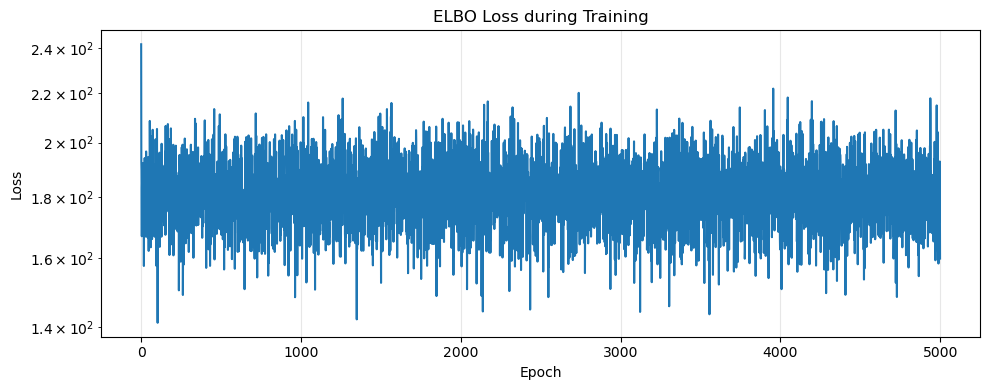

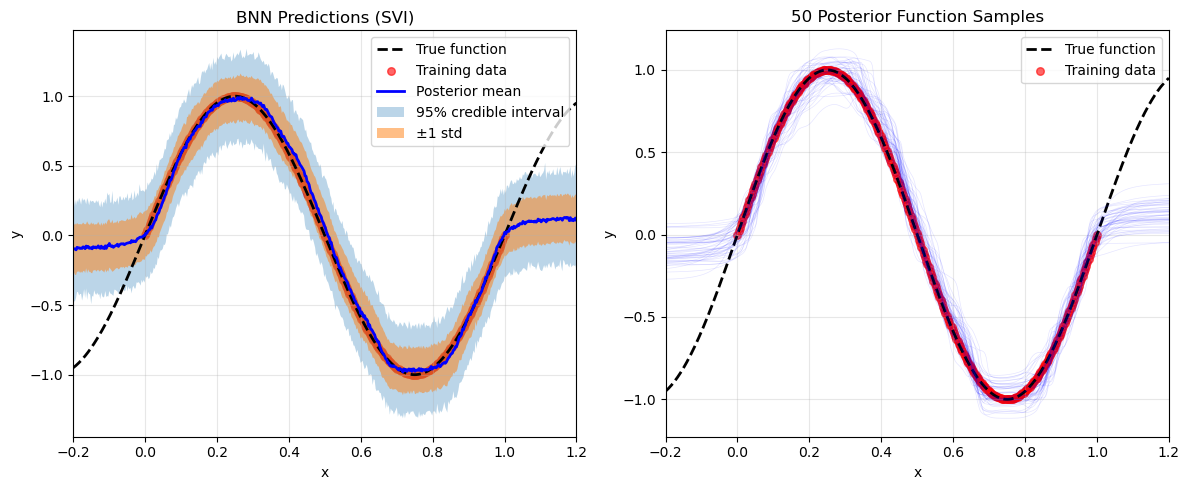


✓ Done! Plot saved as 'bnn_svi_predictions.png'


In [29]:
# ============================================================================

# Training with SVI

# ============================================================================

# Initialize model and guide

# model = BNN(hid_dim=128, prior_scale=1., device=device).to(device)
pyro.clear_param_store()

model = BayesianMMNN(
    ranks=[1] + [32]*3 + [1],
    widths=[128]*4,          # Smaller width
    device=device,
    prior_scale=0.05,
    n_bayesian_layers=2      # Fewer Bayesian layers
)
model.n_data = len(x_train)  # For plate scaling

guide = AutoDiagonalNormal(model)
# optimizer = Adam({"lr": 0.001})
optimizer = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {'lr': 0.01}, 'gamma': 0.1})
svi = SVI(model, guide, scheduler, loss=Trace_ELBO(num_particles=3))

# Mini-batch training
batch_size = 32
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

for epoch in range(500):
    for x_batch, y_batch in train_loader:
        svi.step(x_batch, y_batch)



# Training loop

num_epochs = 5000

losses = []

bar = tqdm.tqdm(range(num_epochs))



for epoch in bar:

    # FIXED: Data already on GPU, no need to convert
    for x_batch, y_batch in train_loader:
        loss = svi.step(x_batch, y_batch)
    scheduler.step()
    losses.append(loss)

    

    if epoch % 100 == 0:

        bar.set_description(f"Epoch {epoch} | Loss: {loss:.2f}")



# ============================================================================

# Visualization: Training Loss

# ============================================================================

plt.figure(figsize=(10, 4))

plt.plot(losses)

plt.title("ELBO Loss during Training")

plt.xlabel("Epoch")

plt.ylabel("Loss")

plt.yscale('log')

plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()



# ============================================================================

# Posterior Predictions

# ============================================================================

model.eval()



# Generate predictions

predictive = Predictive(model, guide=guide, num_samples=500, return_sites=("obs", "_RETURN"))



with torch.no_grad():

    preds = predictive(x_test)



# Extract predictions

y_pred_samples = preds["obs"].detach().cpu().numpy()  # [num_samples, n_test]

y_mu_samples = preds["_RETURN"].detach().cpu().numpy()  # [num_samples, n_test]



# Compute statistics

pred_mean = y_pred_samples.mean(axis=0)

pred_std = y_pred_samples.std(axis=0)

pred_lower = np.percentile(y_pred_samples, 2.5, axis=0)

pred_upper = np.percentile(y_pred_samples, 97.5, axis=0)



# ============================================================================

# Visualization: Predictions

# ============================================================================

plt.figure(figsize=(12, 5))



# Plot 1: Predictions with uncertainty

plt.subplot(1, 2, 1)

x_test_np = x_test.cpu().numpy()

y_true_test_np = y_true_test.cpu().numpy()



plt.plot(x_test_np, y_true_test_np, 'k--', label='True function', linewidth=2)

plt.scatter(x_train_np, y_true_train, c='red', s=30, alpha=0.6, label='Training data')

plt.plot(x_test_np, pred_mean, 'b-', label='Posterior mean', linewidth=2)

plt.fill_between(x_test_np, pred_lower, pred_upper,

                 alpha=0.3, label='95% credible interval')

plt.fill_between(x_test_np, pred_mean - pred_std, pred_mean + pred_std,

                 alpha=0.5, label='±1 std')

plt.xlabel('x')

plt.ylabel('y')

plt.title('BNN Predictions (SVI)')

plt.legend()

plt.grid(True, alpha=0.3)

plt.xlim(-0.2, 1.2)



# Plot 2: Sample posterior functions

plt.subplot(1, 2, 2)

plt.plot(x_test_np, y_true_test_np, 'k--', label='True function', linewidth=2)

plt.scatter(x_train_np, y_true_train, c='red', s=30, alpha=0.6, label='Training data')



# Plot random posterior samples

n_samples_to_plot = 50

sample_indices = np.random.choice(y_pred_samples.shape[0], n_samples_to_plot, replace=False)

for idx in sample_indices:

    plt.plot(x_test_np, y_mu_samples[idx], 'b-', alpha=0.1, linewidth=0.5)



plt.xlabel('x')

plt.ylabel('y')

plt.title(f'{n_samples_to_plot} Posterior Function Samples')

plt.legend()

plt.grid(True, alpha=0.3)

plt.xlim(-0.2, 1.2)



plt.tight_layout()

plt.savefig('bnn_svi_predictions.png', dpi=150, bbox_inches='tight')

plt.show()



print("\n✓ Done! Plot saved as 'bnn_svi_predictions.png'")